In [14]:
import pandas as pd

df = pd.read_csv("auction_results.csv")
df.head()

,brand,model,year,transmission,fuel,displacement_cc,mileage_km,color,winning_price,auction_date,auction_house
0,아우디,A8,2011,자동,휘발유,4163.0,211048.0,회색,4533000.0,2025-03-27,오토마트
1,기아,쏘울,2010,자동,휘발유,1591.0,211718.0,흰색,2119000.0,2025-03-27,오토마트
2,현대,그랜저,2011,자동,휘발유,2359.0,281870.0,흰색,3230000.0,2025-03-27,오토마트
3,BMW,5시리즈,2011,자동,휘발유,2996.0,338928.0,기타,4871000.0,2025-03-27,오토마트
4,현대,벨로스터,2014,자동,휘발유,1591.0,93165.0,빨강(주홍),3720000.0,2025-03-27,오토마트


In [15]:
len(df)

30855

In [16]:
columns_to_check = [col for col in df.columns if col != 'winning_price']

dupes = df[df.duplicated(columns_to_check, keep=False)]

# 동일 키별로 묶어서 winning_price 값들 확인
sample = (
    dupes.groupby(columns_to_check)["winning_price"]
         .apply(list)        # 같은 키에 대한 winning_price들을 리스트로 모음
         .reset_index()
)

sample.head(10)

,brand,model,year,transmission,fuel,displacement_cc,mileage_km,color,auction_date,auction_house,winning_price
0,BMW,1시리즈,2013,오토,경유,1995.0,268885.0,흰색,2025-07-02 00:00:00,오토허브,"[3500000.0, 3500000.0]"
1,BMW,3시리즈,2014,오토,경유,1995.0,268885.0,은색,2025-07-02 00:00:00,오토허브,"[5000000.0, 5000000.0]"
2,BMW,3시리즈,2014,오토,경유,1995.0,268885.0,흰색,2025-05-14 00:00:00,오토허브,"[4800000.0, 4950000.0]"
3,BMW,3시리즈,2015,오토,경유,1995.0,268885.0,기타,2025-07-16 00:00:00,오토허브,"[8050000.0, 8100000.0]"
4,BMW,3시리즈,2015,오토,경유,1995.0,268885.0,흰색,2025-05-21 00:00:00,오토허브,"[8050000.0, 7750000.0]"
5,BMW,3시리즈,2016,오토,경유,1995.0,84442.0,흰색,2025-07-30 00:00:00,오토허브,"[11550000.0, 11550000.0]"
6,BMW,3시리즈,2016,오토,경유,1995.0,268885.0,흰색,2025-07-30 00:00:00,오토허브,"[7100000.0, 9250000.0]"
7,BMW,4시리즈,2015,오토,경유,1995.0,268885.0,기타,2025-04-09 00:00:00,오토허브,"[6750000.0, 6750000.0]"
8,BMW,4시리즈,2015,오토,경유,1995.0,268885.0,흰색,2025-06-04 00:00:00,오토허브,"[8400000.0, 8400000.0]"
9,BMW,5시리즈,2009,오토,휘발유,2996.0,268885.0,기타,2025-04-16 00:00:00,오토허브,"[1750000.0, 1750000.0]"


In [22]:
len(sample)

3126

In [23]:
columns_to_check = [col for col in df.columns if col != "winning_price"]

# 1. winning_price 제외 동일한 키 그룹만 추출
dupes = df[df.duplicated(columns_to_check, keep=False)]

# 2. 그룹별로 winning_price 통계 구하기
group_stats = (
    dupes.groupby(columns_to_check)["winning_price"]
         .agg(["count", "min", "max", "mean", "std"])
         .reset_index()
)

# 3. 가격 간격 계산
group_stats["price_range"] = group_stats["max"] - group_stats["min"]
group_stats["winning_price"] = dupes.groupby(columns_to_check)["winning_price"].apply(list).reset_index()["winning_price"]

# 4. price_range 기준 정렬
largest_gaps = group_stats.sort_values("price_range", ascending=False)

largest_gaps.head(1) # 간격이 가장 큰 상위 10개 그룹 보기


,brand,model,year,transmission,fuel,displacement_cc,mileage_km,color,auction_date,auction_house,count,min,max,mean,std,price_range,winning_price
2424,현대,스타리아,2023,오토,경유,2199.0,42221.0,흰색,2025-05-08 00:00:00,오토허브,3,21800000.0,38050000.0,27400000.0,9.227269e+06,16250000.0,"[22350000.0, 21800000.0, 38050000.0]"


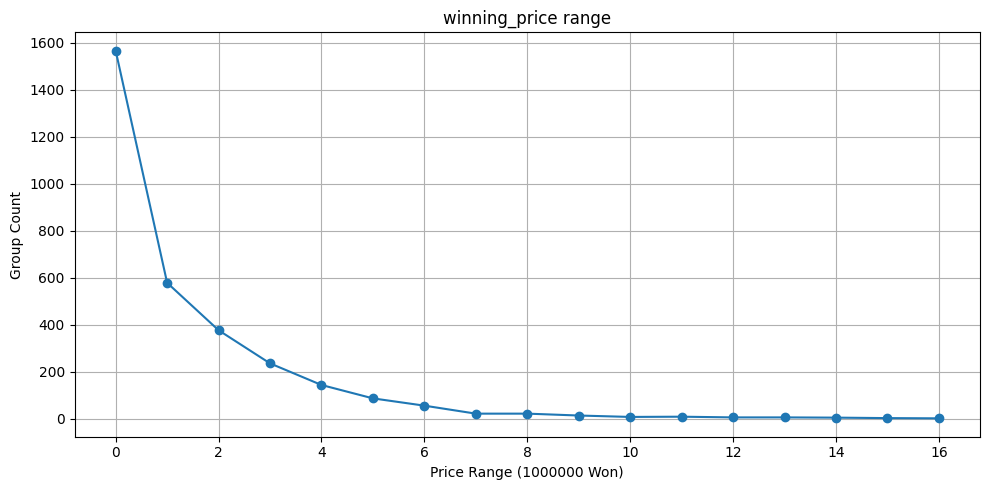

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 1. price_range를 백만 단위로 binning
bin_size = 1_000_000
group_stats["range_bin"] = (group_stats["price_range"] // bin_size).astype(int)  # 몇 백만원 단위인지
group_stats["range_bin_million"] = group_stats["range_bin"]  # 그대로 표시용 (단위: 백만)

# 2. 집계: 각 구간별 개수
bin_counts = (
    group_stats.groupby("range_bin_million")
               .size()
               .reset_index(name="count")
               .sort_values("range_bin_million")
)

# 3. 선 차트
plt.figure(figsize=(10,5))
plt.plot(bin_counts["range_bin_million"], bin_counts["count"], marker="o")
plt.xlabel("Price Range (1000000 Won)")
plt.ylabel("Group Count")
plt.title("winning_price range")
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
def explained_variance(df, group_cols, target="winning_price"):
    """
    그룹 기준에 따라 전체 분산 대비 그룹 설명력을 계산
    + 그룹별 샘플 수 분포까지 출력
    """
    overall_var = df[target].var()

    # 그룹 평균을 각 row에 매핑
    df["group_mean"] = df.groupby(group_cols, observed=True)[target].transform("mean")

    between_var = np.var(df["group_mean"])   # 그룹 간 분산
    explained_ratio = between_var / overall_var

    # 그룹별 샘플 수 확인
    group_sizes = df.groupby(group_cols, observed=True).size()

    return explained_ratio, group_sizes


# 단계별 평가
levels = {
    "차종": ["car_type"],
    "차종+연식": ["car_type", "year"],
    "차종+연식+주행거리": ["car_type", "year", "mileage_bin"],
    "차종+연식+주행거리+색상": ["car_type", "year", "mileage_bin", "color"],
    "차종+연식+주행거리+색상+기어": ["car_type", "year", "mileage_bin", "color", "transmission"],
}

for name, cols in levels.items():
    ratio, sizes = explained_variance(df.copy(), cols)
    print(f"\n{name}")
    print(f"  설명력(R² 유사): {ratio:.3f}")
    print(f"  그룹 개수: {len(sizes)}")
    print(f"  샘플수 요약 → mean={sizes.mean():.1f}, min={sizes.min()}, max={sizes.max()}")



차종
  설명력(R² 유사): 0.421
  그룹 개수: 319
  샘플수 요약 → mean=96.7, min=1, max=2156

차종+연식
  설명력(R² 유사): 0.748
  그룹 개수: 1871
  샘플수 요약 → mean=16.5, min=1, max=481

차종+연식+주행거리
  설명력(R² 유사): 0.807
  그룹 개수: 3751
  샘플수 요약 → mean=8.2, min=1, max=337

차종+연식+주행거리+색상
  설명력(R² 유사): 0.847
  그룹 개수: 7756
  샘플수 요약 → mean=4.0, min=1, max=247

차종+연식+주행거리+색상+기어
  설명력(R² 유사): 0.879
  그룹 개수: 9476
  샘플수 요약 → mean=3.3, min=1, max=137


In [47]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== 설정 =====
OUT_DIR = "price_hists"
os.makedirs(OUT_DIR, exist_ok=True)
from matplotlib import rc

# 맥: AppleGothic, 윈도우: Malgun Gothic, 리눅스: NanumGothic 추천
rc('font', family='AppleGothic')

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 시각화할 그룹 정의 (요청 순서)
GROUP_SETS = [
    ["car_type"],
    ["car_type", "year"],
    ["car_type", "year", "mileage_bin"],
    ["car_type", "year", "mileage_bin", "color"],
    ["car_type", "year", "mileage_bin", "color", "transmission"],
]

# 너무 희소한 그룹은 스킵
MIN_COUNT = 30  # 필요시 10~50 사이로 조정

# 히스토그램 가독성을 위해 극단값 상단 99퍼까지 자름(표시는 p99까지)
CLIP_PCT = 0.99

# ===== 유틸: 안전한 파일명 =====
def safe_name(s: str) -> str:
    return "".join(c if c.isalnum() or c in "-._" else "_" for c in s)

# ===== 유틸: 그룹 단일 시리즈 히스토그램 + 퍼선 라인 =====
def plot_hist_with_quantiles(
    prices: np.ndarray,
    title: str,
    out_path: str,
    bins: int = None
):
    # 가격 배열 정리
    x = np.asarray(prices, dtype=float)
    x = x[np.isfinite(x)]
    if x.size < MIN_COUNT:
        return False, None

    # 상단 tail 클리핑(히스토그램 가독성)
    upper = np.quantile(x, CLIP_PCT)
    x_clip = np.clip(x, 0, upper)

    # bin 개수 자동(Freedman–Diaconis) 또는 기본값
    if bins is None:
        q75, q25 = np.percentile(x_clip, [75, 25])
        iqr = max(q75 - q25, 1e-9)
        bin_width = 2 * iqr / (x_clip.size ** (1/3))
        if bin_width <= 0 or np.isclose(bin_width, 0):
            bins = 50
        else:
            bins = int(max(10, min(200, math.ceil((x_clip.max() - x_clip.min()) / bin_width))))

    # 퍼센타일
    p50 = np.percentile(x, 50)
    p75 = np.percentile(x, 75)
    p90 = np.percentile(x, 90)

    # --- 그림 ---
    plt.figure(figsize=(8, 4.5))
    plt.hist(x_clip, bins=bins)
    # 수직선 (색 지정 금지 규칙: 기본 스타일 사용)
    for v, label in [(p50, "P50"), (p75, "P75"), (p90, "P90")]:
        plt.axvline(v, linestyle="--", linewidth=1.5)
        # 라벨은 약간 위에
        ymax = plt.gca().get_ylim()[1]
        plt.text(v, ymax * 0.95, label, rotation=90, va="top", ha="right", fontsize=9)

    plt.title(title)
    plt.xlabel("Winning Price")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()

    stats = {
        "count": int(x.size),
        "min": float(np.min(x)),
        "p50": float(p50),
        "p75": float(p75),
        "p90": float(p90),
        "max": float(np.max(x)),
        "bins": int(bins),
        "clip_upper": float(upper),
        "saved_path": out_path,
    }
    return True, stats

# ===== 메인: 각 그룹세트 반복 시각화 + 요약표 저장 =====
all_summaries = []
for gset in GROUP_SETS:
    # 그룹 이름 접두사
    prefix = "grp_" + "_".join(gset)
    summary_rows = []

    # 그룹핑
    grouped = df.groupby(gset, dropna=False)
    for keys, sub in grouped:
        cnt = len(sub)
        if cnt < MIN_COUNT:
            continue

        # 키를 문자열로
        if not isinstance(keys, tuple):
            keys = (keys,)
        key_str = "__".join([f"{k}={v}" for k, v in zip(gset, keys)])

        # 파일경로
        fname = f"{prefix}__{safe_name(key_str)}.png"
        out_path = os.path.join(OUT_DIR, fname)

        # 플롯
        ok, stats = plot_hist_with_quantiles(
            prices=sub["winning_price"].values,
            title=f"{' + '.join(gset)} | {key_str} (n={cnt})",
            out_path=out_path
        )
        if ok:
            row = {**{c: v for c, v in zip(gset, keys)}, **stats}
            summary_rows.append(row)

    # 그룹세트별 요약 저장
    if summary_rows:
        df_sum = pd.DataFrame(summary_rows)
        csv_path = os.path.join(OUT_DIR, f"{prefix}__summary.csv")
        df_sum.sort_values("count", ascending=False).to_csv(csv_path, index=False)
        print(f"[INFO] saved {len(df_sum)} plots & summary -> {csv_path}")
        df_sum["group_set"] = "+".join(gset)
        all_summaries.append(df_sum)

# 전체 요약 합치기(선택)
if all_summaries:
    df_all = pd.concat(all_summaries, ignore_index=True)
    df_all.sort_values(["group_set", "count"], ascending=[True, False]).to_csv(
        os.path.join(OUT_DIR, "ALL_summaries.csv"), index=False
    )
    print(f"[INFO] ALL summaries -> {os.path.join(OUT_DIR, 'ALL_summaries.csv')}")
else:
    print("[WARN] No plots generated (consider lowering MIN_COUNT).")


[INFO] saved 103 plots & summary -> price_hists/grp_car_type__summary.csv
[INFO] saved 261 plots & summary -> price_hists/grp_car_type_year__summary.csv


/var/folders/8w/mj69zjzs77d3b41_1hs80lgw0000gn/T/ipykernel_38503/3671839928.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(gset, dropna=False)


[INFO] saved 240 plots & summary -> price_hists/grp_car_type_year_mileage_bin__summary.csv


/var/folders/8w/mj69zjzs77d3b41_1hs80lgw0000gn/T/ipykernel_38503/3671839928.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(gset, dropna=False)


[INFO] saved 147 plots & summary -> price_hists/grp_car_type_year_mileage_bin_color__summary.csv


/var/folders/8w/mj69zjzs77d3b41_1hs80lgw0000gn/T/ipykernel_38503/3671839928.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(gset, dropna=False)


[INFO] saved 113 plots & summary -> price_hists/grp_car_type_year_mileage_bin_color_transmission__summary.csv
[INFO] ALL summaries -> price_hists/ALL_summaries.csv


In [25]:
import numpy as np
import pandas as pd

def add_basic_features(df: pd.DataFrame, *, current_year: int = 2025) -> tuple[pd.DataFrame, list, list]:
    out = df.copy()

    # --- 날짜 처리 ---
    if not np.issubdtype(out["auction_date"].dtype, np.datetime64):
        out["auction_date"] = pd.to_datetime(out["auction_date"], errors="coerce")
    out["auction_year"]   = out["auction_date"].dt.year
    out["auction_month"]  = out["auction_date"].dt.month
    out["auction_quarter"]= out["auction_date"].dt.quarter
    out["auction_dow"]    = out["auction_date"].dt.dayofweek  # 0=월, 6=일
    out["is_month_end"]   = out["auction_date"].dt.is_month_end.astype(int)

    # --- 차량 나이 car_age 정리 ---
    # 음수/비정상 값 보정: year가 미래이거나 너무 과거인 경우 클리핑
    out["year_clean"] = out["year"].clip(lower=1990, upper=current_year)  # 필요시 하한 조정
    out["car_age"]    = (current_year - out["year_clean"]).astype(int)
    # 0세 차량에서 annual_mileage 폭주 방지
    out["car_age_safe"] = out["car_age"].replace(0, 1)

    # --- 주행거리/배기량 이상치 완화 & 로그 ---
    # 퍼센타일 기반 클리핑(이상치로 AM, bin 왜곡 방지)
    def clip_by_q(s: pd.Series, q_low=0.01, q_high=0.99):
        lo, hi = s.quantile(q_low), s.quantile(q_high)
        return s.clip(lower=lo, upper=hi)

    out["mileage_km_clipped"]   = clip_by_q(out["mileage_km"].astype(float))
    out["displacement_cc_clip"] = clip_by_q(out["displacement_cc"].astype(float))

    out["log_mileage"]   = np.log1p(out["mileage_km_clipped"])
    out["engine_liter"]  = out["displacement_cc_clip"] / 1000.0
    out["log_engine_l"]  = np.log1p(out["engine_liter"])

    # --- 연간 주행거리 ---
    out["annual_mileage"] = (out["mileage_km"] / out["car_age_safe"]).replace([np.inf, -np.inf], np.nan)
    # 연간 주행거리도 이상치 클리핑
    out["annual_mileage"] = clip_by_q(out["annual_mileage"].fillna(0))

    # --- 주행거리 구간(bin) ---
    # 데이터 분포 적응형 → 분위수 기반 5구간
    try:
        qcuts = out["mileage_km_clipped"].quantile([0, .2, .4, .6, .8, 1.0]).values
        # 동일 값으로 인해 구간 경계가 겹칠 수 있어 미세 조정
        qcuts = np.unique(qcuts)
        if len(qcuts) < 3:  # 분포가 너무 뭉쳐있다면 고정 구간으로 대체
            bins = [-np.inf, 5e4, 1e5, 2e5, 3e5, np.inf]
        else:
            # 첫/끝에 -inf/+inf 추가
            bins = np.r_[-np.inf, qcuts[1:-1], np.inf]
    except Exception:
        bins = [-np.inf, 5e4, 1e5, 2e5, 3e5, np.inf]

    out["mileage_bin"] = pd.cut(out["mileage_km_clipped"], bins=bins, include_lowest=True).astype(str)

    # --- 카테고리 결측/정규화(공백·대문자 통일 등은 선택) ---
    for c in ["brand", "model", "transmission", "fuel", "color", "auction_house"]:
        out[c] = out[c].astype(str).fillna("unknown")

    # --- CatBoost용 피처 목록 ---
    cat_features = [
        "brand", "model", "transmission", "fuel", "color",
        "auction_house", "mileage_bin"
    ]
    num_features = [
        "year_clean", "car_age", "annual_mileage",
        "mileage_km_clipped", "log_mileage",
        "engine_liter", "log_engine_l",
        "auction_year", "auction_month", "auction_quarter", "auction_dow",
        "is_month_end"
    ]

    return out, cat_features, num_features

# 사용 예시
df_fe, cat_cols, num_cols = add_basic_features(df)
X = df_fe[cat_cols + num_cols]
y = df_fe["winning_price"]


In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold

def add_combo_categories(df: pd.DataFrame) -> tuple[pd.DataFrame, list]:
    """의미 있는 결합 범주 생성"""
    out = df.copy()
    out["brand_model"] = (out["brand"].astype(str) + "_" + out["model"].astype(str))
    out["fuel_transmission"] = (out["fuel"].astype(str) + "_" + out["transmission"].astype(str))
    out["brand_color"] = (out["brand"].astype(str) + "_" + out["color"].astype(str))
    new_cats = ["brand_model", "fuel_transmission", "brand_color"]
    return out, new_cats

def replace_rare_categories(s: pd.Series, min_count: int = 30, rare_token="__RARE__") -> pd.Series:
    """빈도 낮은 카테고리는 희소 토큰으로 묶기"""
    vc = s.value_counts()
    rare = vc[vc < min_count].index
    return s.where(~s.isin(rare), rare_token)

def oof_target_encode(
    df: pd.DataFrame,
    cat_cols: list,
    target_col: str = "winning_price",
    n_splits: int = 5,
    min_count: int = 30,
    global_stat: str = "median",
    random_state: int = 42,
) -> pd.DataFrame:
    """
    누수 없는 OOF 타깃 인코딩.
    - 각 fold의 훈련 부분에서 그룹 평균/중앙값을 만들고 검증 부분에만 적용
    - 희소 카테고리는 희소 토큰으로 치환
    - global_stat: 'mean' or 'median'
    """
    assert global_stat in ("mean", "median")
    out = df.copy()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    global_value = out[target_col].mean() if global_stat == "mean" else out[target_col].median()

    for c in cat_cols:
        # 레어 처리
        out[c + "__rare"] = replace_rare_categories(out[c].astype(str), min_count=min_count)
        enc_col = f"{c}__te_{global_stat}"
        out[enc_col] = np.nan

        for tr_idx, val_idx in kf.split(out):
            tr = out.iloc[tr_idx]
            val = out.iloc[val_idx]
            # 학습 파트에서 그룹 통계 계산
            if global_stat == "mean":
                mapping = tr.groupby(c + "__rare")[target_col].mean()
            else:
                mapping = tr.groupby(c + "__rare")[target_col].median()

            # 검증 파트에만 적용
            out.loc[val_idx, enc_col] = val[c + "__rare"].map(mapping)

        # 매핑 실패(새 카테고리/누락)는 글로벌 값으로 대체
        out[enc_col] = out[enc_col].fillna(global_value)

    # 희소 처리된 원본 컬럼은 학습에 그대로 쓰지 않을 거면 제거 가능(선택)
    # out.drop(columns=[c + "__rare" for c in cat_cols], inplace=True)

    return out

# ===== 사용 예시 =====
# 1) 결합 범주 생성
df_c2, new_cat_cols = add_combo_categories(df_fe)
# 2) OOF 타깃 인코딩 적용(원본+결합 범주 모두에 대해)
base_cat = ["brand", "model", "transmission", "fuel", "color", "auction_house", "mileage_bin"]
te_cols = base_cat + new_cat_cols
df_c2 = oof_target_encode(df_c2, te_cols, target_col="winning_price", n_splits=5, min_count=30)

# 3) CatBoost에 사용할 컬럼 구성
cat_cols_final = base_cat + new_cat_cols   # 문자열 범주들(그대로 투입)
num_cols_final = num_cols + [f"{c}__te_median" for c in te_cols]  # 또는 median 선택
X = df_c2[cat_cols_final + num_cols_final]
y = df_c2["winning_price"]


In [33]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from catboost import CatBoostRegressor, Pool

# ==== 준비: 컬럼 지정 (2단계 결과를 그대로 사용) ====
# cat_cols_final = base_cat + new_cat_cols
# num_cols_final = num_cols + [f"{c}__te_mean" for c in te_cols]  # 또는 median 사용했다면 __te_median
all_feat_cols = cat_cols_final + num_cols_final
target_col = "winning_price"

# ==== 시계열 분할 (auction_date 최근 20%를 검증으로) ====
df_trainable = df_c2.dropna(subset=[target_col]).copy()
if not np.issubdtype(df_trainable["auction_date"].dtype, np.datetime64):
    df_trainable["auction_date"] = pd.to_datetime(df_trainable["auction_date"], errors="coerce")

df_trainable = df_trainable.sort_values("auction_date").reset_index(drop=True)

n = len(df_trainable)
split_idx = int(n * 0.8)
train_df = df_trainable.iloc[:split_idx]
valid_df = df_trainable.iloc[split_idx:]
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool

# ===== 데이터 준비 (이전 단계 동일) =====
X_tr, y_tr = train_df[all_feat_cols], train_df["winning_price"].values
X_va, y_va = valid_df[all_feat_cols], valid_df["winning_price"].values

# ---- 로그 타깃 ----
y_tr_log = np.log1p(y_tr)

train_pool = Pool(X_tr, y_tr_log, cat_features=cat_idx)
valid_pool = Pool(X_va, np.log1p(y_va), cat_features=cat_idx)

# ===== 모델 (부트스트랩 충돌 해결 버전: Bayesian + subsample 제거) =====
model_log = CatBoostRegressor(
    loss_function="RMSE",
    iterations=20000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=6.0,
    random_strength=0.8,
    bootstrap_type="Bayesian",
    grow_policy="SymmetricTree",
    eval_metric="RMSE",
    task_type="CPU",  # GPU면 "GPU"
    verbose=200
)
model_log.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True,
    early_stopping_rounds=800
)

# ===== 검증 예측(로그스케일) → 원화 복원 =====
pred_log_va = model_log.predict(valid_pool)

# 분산 보정 없이 복원
pred_price_raw = np.expm1(pred_log_va)

# --- 로그스케일 잔차 분산 추정 후 보정 계수 계산 ---
# 가정: log(가격) 잔차 ~ N(0, σ^2) → E[exp(resid)] = exp(σ^2/2)
resid_log = np.log1p(y_va) - pred_log_va
sigma2 = np.var(resid_log)
bias_factor = np.exp(sigma2 / 2.0)

pred_price_adj = np.clip(pred_price_raw * bias_factor, 0, None)

# ===== 평가(원화 스케일) =====
mse_raw = mean_squared_error(y_va, pred_price_raw)
rmse_raw = np.sqrt(mse_raw)

mse_adj = mean_squared_error(y_va, pred_price_adj)
rmse_adj = np.sqrt(mse_adj)

r2_adj = r2_score(y_va, pred_price_adj)
denom = np.clip(np.abs(y_va), 1e3, None)
mape_adj = np.mean(np.abs((y_va - pred_price_adj) / denom))

print(f"[VALID][log-target] RMSE(raw): {rmse_raw:,.0f}")
print(f"[VALID][log-target] RMSE(adj): {rmse_adj:,.0f} | R²: {r2_adj:.4f} | MAPE: {mape_adj*100:.2f}%")
print(f"[INFO] log-resid variance σ²={sigma2:.5f} -> bias factor={bias_factor:.5f}")

# ===== 저장 =====
model_log.save_model("cat_model_log.cbm")
pd.DataFrame({
    "feature": all_feat_cols,
    "importance": model_log.get_feature_importance(train_pool)
}).sort_values("importance", ascending=False).to_csv("feature_importance_log.csv", index=False)

# ===== 추론용 함수 =====
def predict_price_log_model(df_new: pd.DataFrame, use_bias_correction: bool = True) -> np.ndarray:
    pool = Pool(df_new[all_feat_cols], cat_features=cat_idx)
    pred_log = model_log.predict(pool)
    price = np.expm1(pred_log)
    if use_bias_correction:
        return np.clip(price * bias_factor, 0, None)
    return np.clip(price, 0, None)


0:	learn: 0.8231207	test: 0.9861521	best: 0.9861521 (0)	total: 16.3ms	remaining: 5m 25s
200:	learn: 0.2706952	test: 0.3988385	best: 0.3988385 (200)	total: 3.25s	remaining: 5m 20s
400:	learn: 0.2467107	test: 0.3864925	best: 0.3864925 (400)	total: 6.47s	remaining: 5m 16s
600:	learn: 0.2355239	test: 0.3819746	best: 0.3819609 (599)	total: 10.1s	remaining: 5m 25s
800:	learn: 0.2276146	test: 0.3798587	best: 0.3797042 (788)	total: 13.4s	remaining: 5m 21s
1000:	learn: 0.2216755	test: 0.3793765	best: 0.3792789 (995)	total: 16.7s	remaining: 5m 17s
1200:	learn: 0.2168746	test: 0.3783758	best: 0.3783420 (1181)	total: 20s	remaining: 5m 13s
1400:	learn: 0.2120302	test: 0.3775579	best: 0.3775271 (1348)	total: 23.2s	remaining: 5m 8s
1600:	learn: 0.2077353	test: 0.3773762	best: 0.3773762 (1600)	total: 26.4s	remaining: 5m 3s
1800:	learn: 0.2039488	test: 0.3763630	best: 0.3763539 (1796)	total: 29.7s	remaining: 5m
2000:	learn: 0.2004632	test: 0.3755654	best: 0.3755654 (2000)	total: 32.9s	remaining: 4m 56s

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

# ===== 데이터 준비 =====
X_tr, y_tr = train_df[all_feat_cols], train_df["winning_price"].values
X_va, y_va = valid_df[all_feat_cols], valid_df["winning_price"].values

# --- 범주형 변수를 Label Encoding ---
X_tr_enc = X_tr.copy()
X_va_enc = X_va.copy()

for col in cat_cols_final:
    le = LabelEncoder()
    le.fit(list(X_tr[col].astype(str).values) + list(X_va[col].astype(str).values))
    X_tr_enc[col] = le.transform(X_tr[col].astype(str).values)
    X_va_enc[col] = le.transform(X_va[col].astype(str).values)

# ===== LightGBM Dataset =====
train_set = lgb.Dataset(X_tr_enc, label=y_tr)
valid_set = lgb.Dataset(X_va_enc, label=y_va)

# ===== 모델 =====
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",   # gradient boosting
    "num_leaves": 64,
    "learning_rate": 0.05,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "verbose": -1,
}

model_lgb = lgb.train(
    params,
    train_set,
    valid_sets=[train_set, valid_set],
    num_boost_round=20000,
)

# ===== 평가 =====
pred_va = model_lgb.predict(X_va_enc, num_iteration=model_lgb.best_iteration)

rmse = np.sqrt(mean_squared_error(y_va, pred_va))
r2 = r2_score(y_va, pred_va)
denom = np.clip(np.abs(y_va), 1e3, None)
mape = np.mean(np.abs((y_va - pred_va) / denom))

print(f"[VALID][LightGBM] RMSE: {rmse:,.0f} | R²: {r2:.4f} | MAPE: {mape*100:.2f}%")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2674
[LightGBM] [Info] Number of data points in the train set: 24684, number of used features: 32
[LightGBM] [Info] Start training from score 13574514.745422
[VALID][LightGBM] RMSE: 5,619,241 | R²: 0.8075 | MAPE: 50.33%


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, DMatrix

# ===== 데이터 분리 (이미 준비되어 있다고 가정) =====
X_tr, y_tr = train_df[all_feat_cols].copy(), train_df["winning_price"].values
X_va, y_va = valid_df[all_feat_cols].copy(), valid_df["winning_price"].values

# ===== 범주형 인코딩(LabelEncoder) =====
encoders = {}
for col in cat_cols_final:
    le = LabelEncoder()
    # train+valid 합쳐서 fit → 검증 셋 unseen 카테고리 방지
    le.fit(list(X_tr[col].astype(str).values) + list(X_va[col].astype(str).values))
    X_tr[col] = le.transform(X_tr[col].astype(str).values)
    X_va[col] = le.transform(X_va[col].astype(str).values)
    encoders[col] = le

# XGBoost는 float32가 빠르고 메모리 이점
X_tr = X_tr.astype(np.float32)
X_va = X_va.astype(np.float32)

# ===== 모델 설정 =====
# GPU 사용 가능하면 tree_method="gpu_hist", predictor="gpu_predictor"
use_gpu = False  # 필요 시 True로
xgb_params = dict(
    n_estimators=20000,
    learning_rate=0.03,
    max_depth=8,
    min_child_weight=5.0,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,   # L1
    reg_lambda=1.0,  # L2
    objective="reg:squarederror",
    eval_metric="rmse",
    tree_method="gpu_hist" if use_gpu else "hist",
    predictor="gpu_predictor" if use_gpu else "auto",
    random_state=42,
)

model_xgb = XGBRegressor(**xgb_params)

# ===== 학습 (Early Stopping) =====
model_xgb.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    verbose=200,
)

# ===== 평가 =====
pred_va = model_xgb.predict(X_va, iteration_range=(0, model_xgb.best_iteration+1))

rmse = np.sqrt(mean_squared_error(y_va, pred_va))
r2   = r2_score(y_va, pred_va)
denom = np.clip(np.abs(y_va), 1e3, None)
mape = np.mean(np.abs((y_va - pred_va) / denom))

print(f"[VALID][XGB] best_iter={model_xgb.best_iteration}  "
      f"RMSE: {rmse:,.0f} | R²: {r2:.4f} | MAPE: {mape*100:.2f}%")

# ===== 저장 =====
import joblib
joblib.dump(model_xgb, "xgb_model.joblib")
print("[INFO] model saved -> xgb_model.joblib")

# ===== 추론 함수 =====
def predict_price_xgb(df_new: pd.DataFrame) -> np.ndarray:
    df_enc = df_new[all_feat_cols].copy()
    for col, le in encoders.items():
        df_enc[col] = le.transform(df_enc[col].astype(str).fillna("nan"))
    df_enc = df_enc.astype(np.float32)
    return model_xgb.predict(df_enc, iteration_range=(0, model_xgb.best_iteration+1))


[0]	validation_0-rmse:12561107.82627


/opt/miniconda3/envs/softeer/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:15:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:5332957.70365
[400]	validation_0-rmse:5223807.03128
[600]	validation_0-rmse:5202771.75043
[800]	validation_0-rmse:5186294.71058
[1000]	validation_0-rmse:5180366.84227
[1200]	validation_0-rmse:5185835.28280
[1400]	validation_0-rmse:5192818.03235
[1600]	validation_0-rmse:5196470.07286
[1800]	validation_0-rmse:5201644.45678
[2000]	validation_0-rmse:5206322.98991
[2200]	validation_0-rmse:5210231.80264
[2400]	validation_0-rmse:5216147.37458
[2600]	validation_0-rmse:5219422.12758
[2800]	validation_0-rmse:5224601.28255
[3000]	validation_0-rmse:5227464.89284
[3200]	validation_0-rmse:5231443.56668
[3400]	validation_0-rmse:5234626.72790
[3600]	validation_0-rmse:5236747.32590
[3800]	validation_0-rmse:5239707.36217
[4000]	validation_0-rmse:5241072.63736
[4200]	validation_0-rmse:5242305.61932
[4400]	validation_0-rmse:5244530.90456
[4600]	validation_0-rmse:5247318.93874
[4800]	validation_0-rmse:5248000.26159
[5000]	validation_0-rmse:5249972.16550
[5200]	validation_0-rmse:5250

AttributeError: `best_iteration` is only defined when early stopping is used.